## **Time Series Anomaly Detection with Autoencoders**
**Intro:** Currently, I'm working a bit on time series anomaly detection and wanted to share this notebook in which I implemented a lstm autoencoder in pytorch and applied it on the new york city taxi data from the numenta anomaly benchmark (NAB). It was especially interesting for me in comparison with [this notebook](https://www.kaggle.com/code/lkskrk/time-series-anomaly-detection-via-isolation-forest) where I used the isolation forest algorithm on the same problem. Autoencoders are often trained on only the normal data without containing the anomalies although it can often significantly reduce the data preparation effort if you can just use all of the data for training. In the following, we will show that it is possible to succesfully train autoencoders on data also containing the anomalies and will visualize all respective results with matplotlib and seaborn.

**LSTM Autoencoders:** From [this link](https://machinelearningmastery.com/lstm-autoencoders/): "An LSTM Autoencoder is an implementation of an autoencoder for sequence data using an Encoder-Decoder LSTM architecture. For a given dataset of sequences, an encoder-decoder LSTM is configured to read the input sequence, encode it, decode it, and recreate it. The performance of the model is evaluated based on the model’s ability to recreate the input sequence."

**With this in mind, let's now use this to build a model for detecting anomalies!**

## **Importing Libraries**

In [1]:
# Import code
import numpy as np 
import pandas as pd
#import matplotlib.dates as mdates
#from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## **Understanding the Data**
For this notebook, we will use the **new york city taxi data** from the **numenta anomaly benchmark (NAB)**. The value column in the data contains the number of NYC taxi passengers and results from aggregating the total number of taxi passengers into 30 minute buckets. Let's have a look at the data:

In [2]:
df = pd.read_csv('/kaggle/input/realKnownCause/realKnownCause/nyc_taxi.csv', parse_dates=['timestamp'])
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [3]:
df.describe()

,timestamp,value
count,10320,10320.000000
mean,2014-10-16 11:45:00,15137.569380
min,2014-07-01 00:00:00,8.000000
25%,2014-08-23 17:52:30,10262.000000
50%,2014-10-16 11:45:00,16778.000000
75%,2014-12-09 05:37:30,19838.750000
max,2015-01-31 23:30:00,39197.000000
std,NaN,6939.495808


In [4]:
df.isnull().sum()

timestamp    0
value        0
dtype: int64

Cool, there are no missing values, so we don't have to worry about imputation :). Let's check out the time frame of the data:

In [5]:
print('Start time: ', df['timestamp'].min())
print('End time: ', df['timestamp'].max())
print('Time difference: ', df['timestamp'].max()-df['timestamp'].min())

Start time:  2014-07-01 00:00:00
End time:  2015-01-31 23:30:00
Time difference:  214 days 23:30:00


## **Data Visualization**
Let's now visualize the data to get a better understanding of it. We use resampling on the data to be able to see patterns of different frequencies.

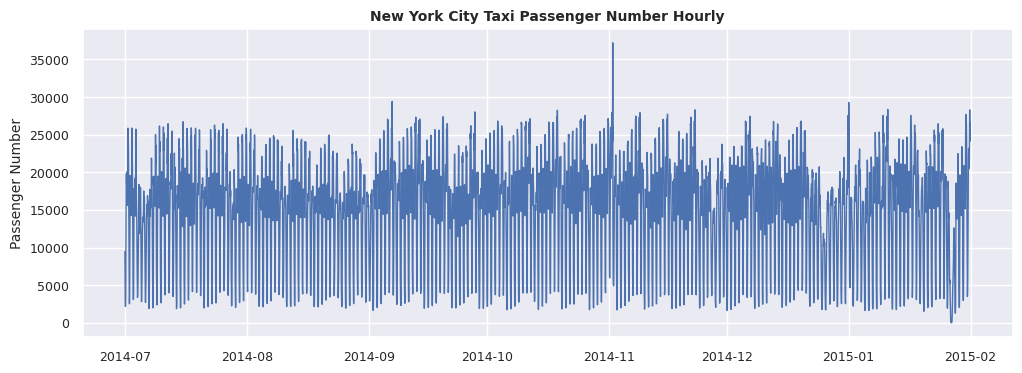

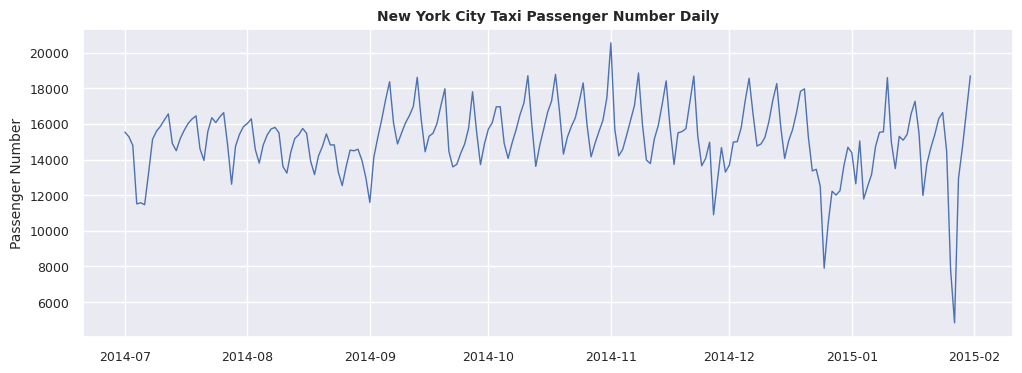

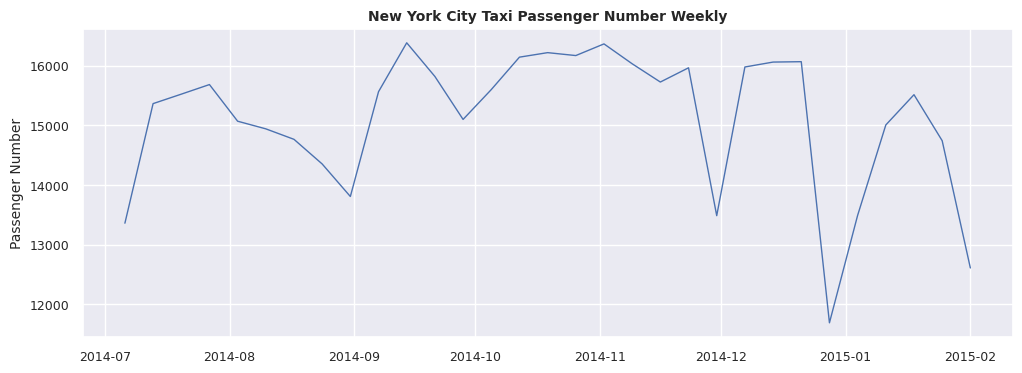

In [6]:
sns.set(rc={'figure.figsize':(12, 4)})

fig1, ax1 = plt.subplots()
sns.lineplot(data=df.set_index('timestamp').resample('H').mean(), ax=ax1, x="timestamp", y="value", linewidth=1)
ax1.axes.set_title("New York City Taxi Passenger Number Hourly",fontsize=10, weight='bold')
ax1.set_xlabel("",fontsize=10)
ax1.set_ylabel("Passenger Number",fontsize=10)
ax1.tick_params(labelsize=9)
plt.legend([],[], frameon=False)

fig2, ax2 = plt.subplots()
sns.lineplot(data=df.set_index('timestamp').resample('D').mean(), ax=ax2, x="timestamp", y="value", linewidth=1)
ax2.axes.set_title("New York City Taxi Passenger Number Daily",fontsize=10, weight='bold')
ax2.set_xlabel("",fontsize=10)
ax2.set_ylabel("Passenger Number",fontsize=10)
ax2.tick_params(labelsize=9)
plt.legend([],[], frameon=False)

fig3, ax3 = plt.subplots()
sns.lineplot(data=df.set_index('timestamp').resample('W').mean(), ax=ax3, x="timestamp", y="value", linewidth=1)
ax3.axes.set_title("New York City Taxi Passenger Number Weekly",fontsize=10, weight='bold')
ax3.set_xlabel("",fontsize=10)
ax3.set_ylabel("Passenger Number",fontsize=10)
ax3.tick_params(labelsize=9)
plt.legend([],[], frameon=False)

plt.show()

We are now interested in identifying anomaly events where both the value and the gradient of the passenger number are significant different compared to the rest of the data. Based on this, in the second plot, it is possible to identify 6 anomalies with the following dates (in order to identify the exact days, it helps to print out the corresponding parts of the data frame):
* 2014-07-05
* 2014-09-01
* 2014-11-01
* 2014-11-27
* 2014-12-25
* 2015-01-27.

Our goal is now to build a lstm autoencoder which detects these points as anomalies. In order to have a clean setting, we will split the data set into train (containing the first 3 anomalies) and test (containing the last 3 anomalies) sets. The train set will be used for training and parameter tuning and on the test set we will check if our model generalizes well to new data.

## **Modeling**
We first split our data into train and test sets and we will then only use the train set for model training and algorithmic design decisions:

In [7]:
# Split data into train (~2/3 of data) and test (~1/3 of data) sets
df_train_split, df_test_split = np.split(df, [int(0.65 *len(df))])

We will now use the next plot to determine the resample frequency and the length of the sequences best suited for our anomaly detection problem. For this, we will only use the training data:

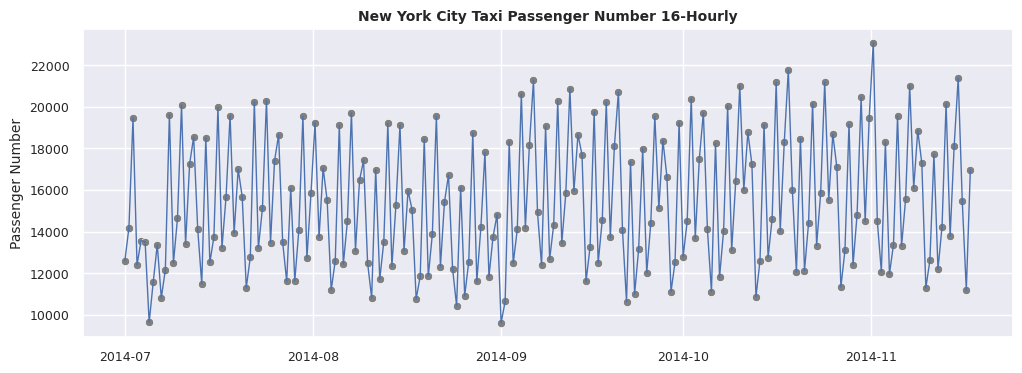

In [8]:
df_eda = df_train_split.set_index('timestamp').resample('16H').mean().iloc[:]
sns.set(rc={'figure.figsize':(12, 4)})
fig1, ax1 = plt.subplots()
sns.lineplot(data=df_eda, ax=ax1, x="timestamp", y="value", linewidth=1)
sc=sns.scatterplot(data=df_eda, ax=ax1, x="timestamp", y="value", color='grey')
ax1.axes.set_title("New York City Taxi Passenger Number 16-Hourly",fontsize=10, weight='bold')
ax1.set_xlabel("",fontsize=10)
ax1.set_ylabel("Passenger Number",fontsize=10)
ax1.tick_params(labelsize=9)
plt.legend([],[], frameon=False)
plt.show()

Through trying out different resample frequencies, we can find that resampling into 16-hour intervals is a good trade off between downsampling the data and still being able to clearly see the anomalies. Also, using data sequences consisting of three consecutive data points (i.e. the value at the corresponding timestep + two lags (values into the past)) seems to be a good fit for discriminating between the normal data points and the anomalies. We use these parameters now for resampling the data and adding the two lag features:

In [9]:
df_train_split, df_test_split=[df.set_index('timestamp').resample('16H').mean().reset_index() for df in [df_train_split, df_test_split]]

number_of_lags = 2
for i in range(number_of_lags):
    df_train_split[f'lag{i+1}'] = df_train_split['value'].shift(i+1)
    df_test_split[f'lag{i+1}'] = df_test_split['value'].shift(i+1)
    
df_train_split, df_test_split=[df.dropna() for df in [df_train_split, df_test_split]]

In [10]:
df_train_split.head()

,timestamp,value,lag1,lag2
2,2014-07-02 08:00:00,19442.34375,14191.37500,12604.00000
3,2014-07-03 00:00:00,12395.43750,19442.34375,14191.37500
4,2014-07-03 16:00:00,13561.46875,12395.43750,19442.34375
5,2014-07-04 08:00:00,13502.68750,13561.46875,12395.43750
6,2014-07-05 00:00:00,9623.56250,13502.68750,13561.46875


In [11]:
df_test_split.head()

,timestamp,value,lag1,lag2
2,2014-11-19 00:00:00,12818.96875,20016.68750,11700.714286
3,2014-11-19 16:00:00,14323.71875,12818.96875,20016.687500
4,2014-11-20 08:00:00,19810.21875,14323.71875,12818.968750
5,2014-11-21 00:00:00,14087.68750,19810.21875,14323.718750
6,2014-11-21 16:00:00,18031.84375,14087.68750,19810.218750


We now define the features from above to be used in the model training:

In [12]:
# Define model features
features = ['value']
for i in range(2):
    features.append(f'lag{i+1}')
df_train = df_train_split[features]
df_test = df_test_split[features]

Based on this, we can now start to build up our lstm autoencoder model using pytorch.

First, we normalize the features to the range [0,1] with the MinMaxScaler:

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(df_train)
X_test = scaler.transform(df_test)

We convert the type of our data because pytorch's default floating point dtype is float32:

In [14]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Next, we define pytorch tensors based on our train and test data:

In [15]:
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)

Then, we define a CustomDataset class for our data to be able to be used by the pytorch Dataloader:

In [16]:
class CustomDataset(Dataset):
    def __init__(self, tensor_data,):
        self.tensor_data = tensor_data

    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, idx):
        data_point = self.tensor_data[idx]
        return data_point

    
training_data = CustomDataset(
    X_train_tensor)

test_data = CustomDataset(
    X_test_tensor)

Next, we set the hyperparameters for our model and training procedure, define the train and test data loaders thereafter and can then set the device used for the training:

In [17]:
seq_len = 3
n_features = 1
embedding_dim = 32
batch_size = 32
lr= 0.001
epochs = 500
torch.manual_seed(1)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Get cpu, gpu or mps device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


Now, we can finally implement our autoencoder model. For this, we first define the Encoder and Decoder classes with their respective forward pass methods and use these two parts then to define the Autoencoder class with its forward pass:

In [18]:
# Define encoder
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim
        
        self.rnn1 = nn.LSTM(
          input_size=self.n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=self.embedding_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn3 = nn.LSTM(
          input_size=self.embedding_dim,
          hidden_size=self.embedding_dim,
          num_layers=1,
          batch_first=True
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        x, (h_n, c_n) = self.rnn1(x)
        x, (h_n, c_n) = self.rnn2(x)
        x, (h_n, c_n) = self.rnn3(x)
        return h_n.reshape((batch_size, self.embedding_dim))


# Define decoder
class Decoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim
        
        self.rnn1 = nn.LSTM(
          input_size=embedding_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=embedding_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn3 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, (h_n, c_n) = self.rnn1(x)
        x, (h_n, c_n) = self.rnn2(x)
        x, (h_n, c_n) = self.rnn3(x)
        return self.output_layer(x)

    
# Define autoencoder
class Autoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, n_features, embedding_dim).to(device)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Based on this, we now define our model for the training as an object of the Autoencoder class, choose the mean squared error as the loss function to be used and also define AdamW and Cosine Annealing as the optimizer and learning rate scheduler respectively:

In [19]:
model = Autoencoder(seq_len, n_features, embedding_dim)
model = model.to(device)
loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

Let's print a summary of our model to get an overview:

In [20]:
summary(model, (batch_size, seq_len, n_features))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 3, 1]                --
├─Encoder: 1-1                           [32, 32]                  --
│    └─LSTM: 2-1                         [32, 3, 64]               17,152
│    └─LSTM: 2-2                         [32, 3, 32]               12,544
│    └─LSTM: 2-3                         [32, 3, 32]               8,448
├─Decoder: 1-2                           [32, 3, 1]                --
│    └─LSTM: 2-4                         [32, 3, 32]               8,448
│    └─LSTM: 2-5                         [32, 3, 64]               25,088
│    └─LSTM: 2-6                         [32, 3, 64]               33,280
│    └─Linear: 2-7                       [32, 3, 1]                65
Total params: 105,025
Trainable params: 105,025
Non-trainable params: 0
Total mult-adds (M): 10.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.42
Estimated Total Size 

That looks good, that means we can now define a function for executing one training epoch...

In [21]:
# Define training step involving prediction, loss calculation and backprop
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    loss_training_epoch = []
    for counter, X in enumerate(dataloader):
        # Add feature dimension at the end of tensor
        # Currently needed because there is only one feature
        # and dimension is otherwise missing
        X = torch.unsqueeze(X, 2)
        X = X.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, X)
                
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss = loss.item()
        loss_training_epoch.append(loss)
    return loss_training_epoch

... and can then finally start the model training using this function together with updating the learning rate scheduler after each training epoch:

Training done!


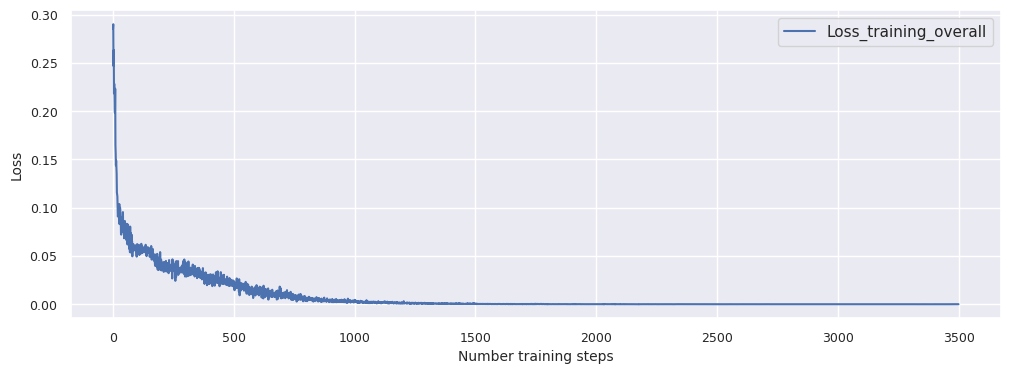

In [22]:
loss_training_overall = []
for t in range(epochs):
    loss_training_epoch = train(train_dataloader, model, loss_fn, optimizer)
    loss_training_overall = loss_training_overall + loss_training_epoch
    scheduler.step()
print("Training done!")

# Plot training loss
fig = plt.figure()
plt.plot(loss_training_overall, label='Loss_training_overall')
plt.xlabel('Number training steps', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.tick_params(labelsize=9)
plt.legend()
plt.show()

We can see that we successfully trained our model to reconstruct the input sequences of the training set :)! Let's now use the trained model to plot some sequences together with their reconstruction and their corresponding reconstruction error (we use the l1 metric for calculating the reconstruction errors):

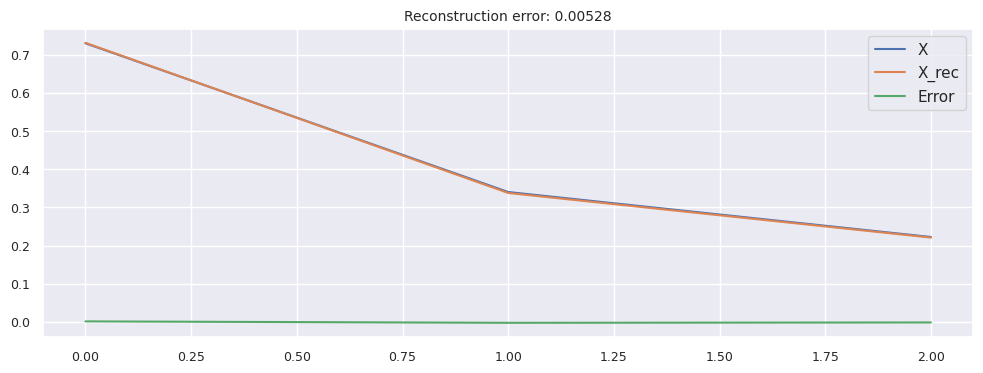

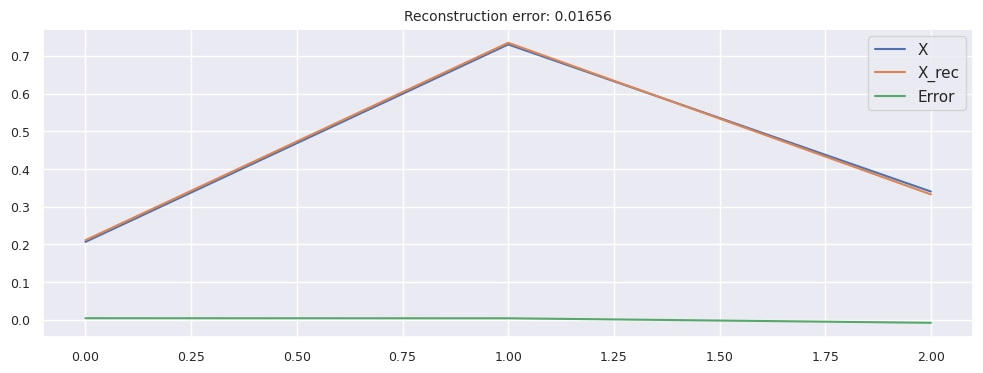

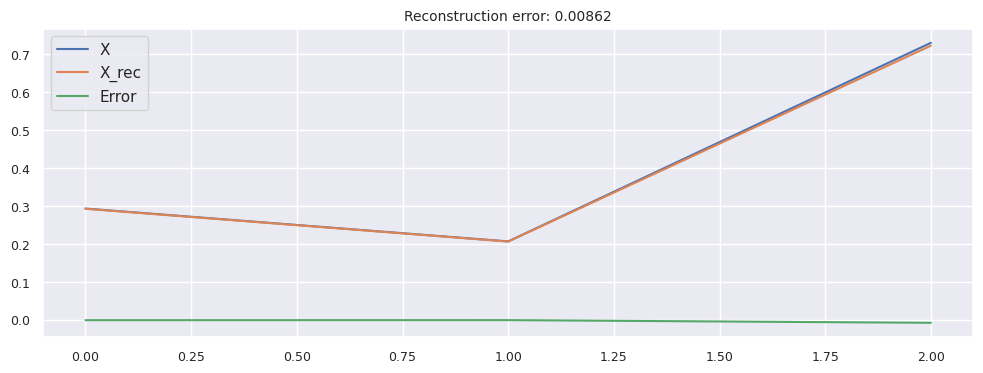

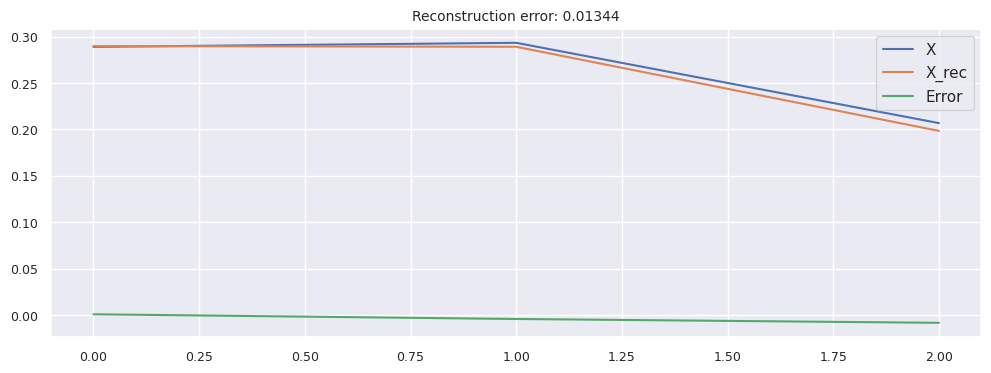

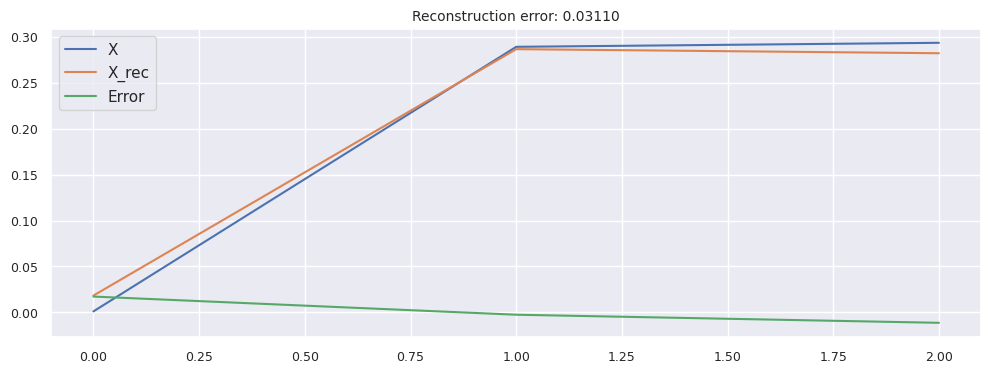

In [23]:
with torch.no_grad():
    X = X_train_tensor
    X = torch.unsqueeze(X, 2)
    X = X.to(device)
    reconstruction_training_data = model(X)
    difference_seqs = reconstruction_training_data-X
    reconstruction_errors_training = torch.sum(torch.abs(difference_seqs), dim=1)
    for i in range(5):
        plt.plot(X[i], label='X')
        plt.plot(reconstruction_training_data[i], label='X_rec')
        plt.plot(difference_seqs[i], label='Error')
        plt.title(f'Reconstruction error: {reconstruction_errors_training[i].item():.5f}', fontsize=10)
        plt.tick_params(labelsize=9)
        plt.legend()
        plt.show()

That looks good overall and we can now continue to plot the reconstruction error distribution to determine the threshold for deciding if a sequence is an anomaly or not:

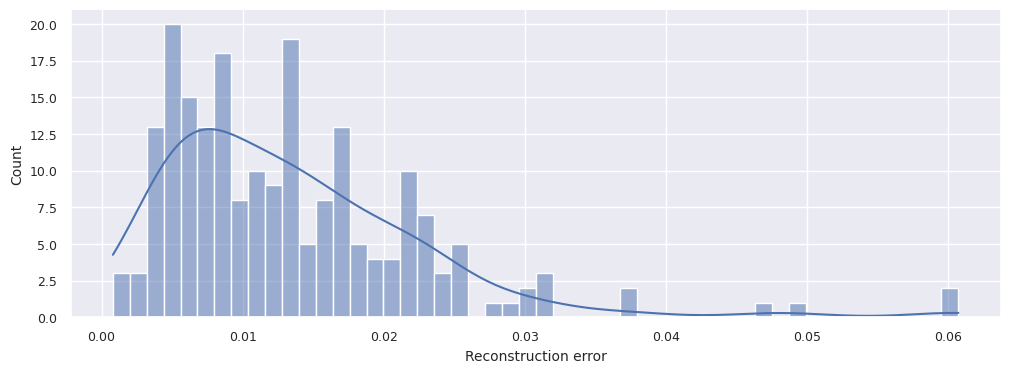

In [24]:
ax = sns.histplot(data=reconstruction_errors_training.numpy(), bins=50, kde=True)
ax.set_xlabel('Reconstruction error',fontsize=10)
ax.set_ylabel('Count',fontsize=10)
ax.tick_params(labelsize=9)
plt.legend([],[], frameon=False)
plt.show()

Based on this and having in mind that the train dataset contains 3 anomalies, a theshold of 0.048 seems to be a good choice and we can then use this threshold to determine the anomalies of the training set...

In [25]:
reconstruction_error_threshold = 0.048
outliers_train = np.where(reconstruction_errors_training.flatten() > reconstruction_error_threshold, 1, 0)

... and add these anomaly results to the data frame so that we can visualize them later on:

In [26]:
df_train_split = df_train_split.assign(outliers = outliers_train)
df_train_split = df_train_split.assign(anomaly_score = reconstruction_errors_training.flatten())
df_train_split.head()

,timestamp,value,lag1,lag2,outliers,anomaly_score
2,2014-07-02 08:00:00,19442.34375,14191.37500,12604.00000,0,0.005281
3,2014-07-03 00:00:00,12395.43750,19442.34375,14191.37500,0,0.016557
4,2014-07-03 16:00:00,13561.46875,12395.43750,19442.34375,0,0.008623
5,2014-07-04 08:00:00,13502.68750,13561.46875,12395.43750,0,0.013443
6,2014-07-05 00:00:00,9623.56250,13502.68750,13561.46875,0,0.031103


We can also double check the number of anomalies we predicted for the training set:

In [27]:
df_train_split['outliers'].sum()

3

Ok, that sounds good. Let's now visualize the anomalies (in red) and also the normal data points (in green) to get a better overview:

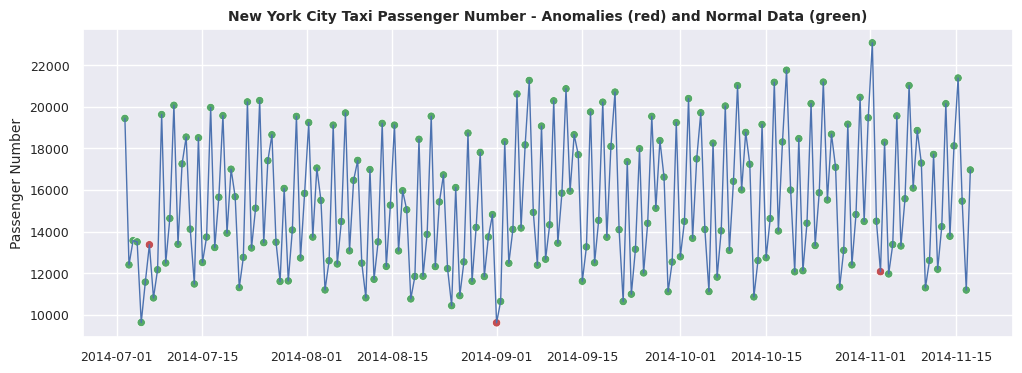

In [28]:
fig, ax = plt.subplots()
sns.lineplot(data=df_train_split, ax=ax, x="timestamp", y="value", linewidth=1)
sns.scatterplot(data=df_train_split, x="timestamp", y="value", ax=ax, hue="outliers", palette={1:'r', 0:'g'})
ax.axes.set_title("New York City Taxi Passenger Number - Anomalies (red) and Normal Data (green)",fontsize=10, weight='bold')
ax.set_xlabel("",fontsize=10)
ax.set_ylabel("Passenger Number",fontsize=10)
ax.tick_params(labelsize=9)
plt.legend([],[], frameon=False)
plt.show()

We can see that the 3 detected anomalies indeed belong to the 3 abnormal events we defined for the training set (for the last event, we detect the anomaly quite late though), so that worked quite good so far :).

After the model training and threshold definition is done, let's now try the model together with the determined threshold on the test data to see how good it generalizes to new data:

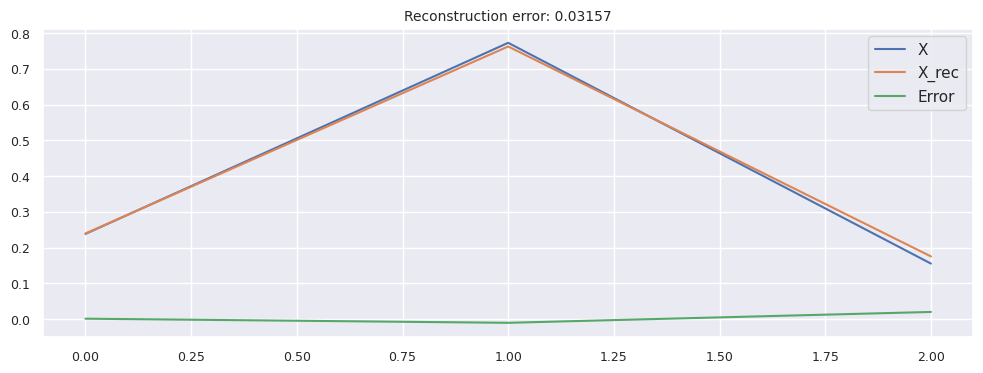

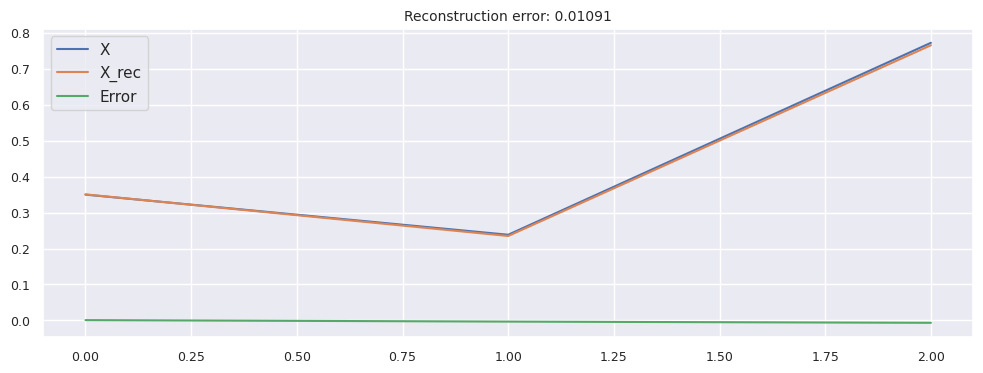

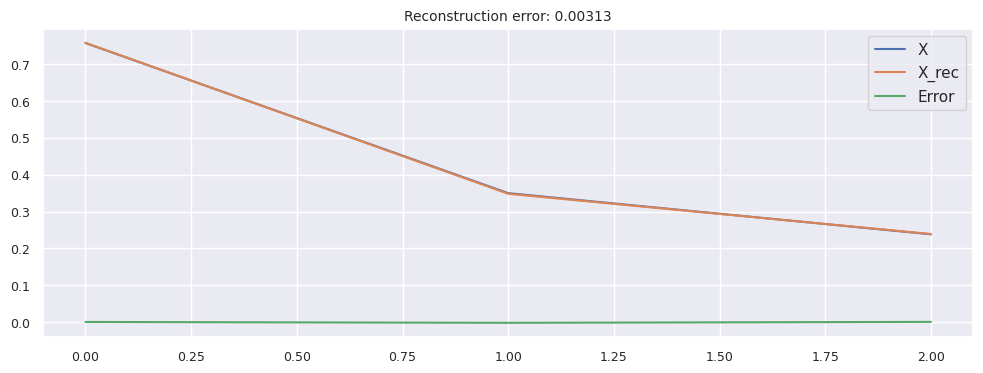

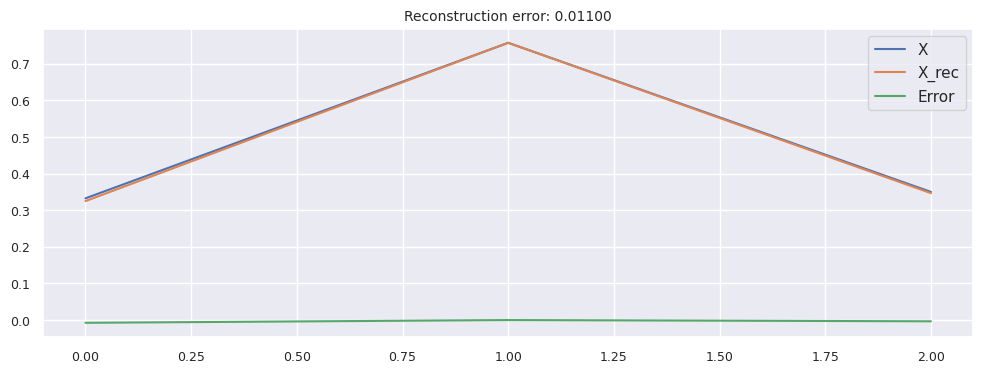

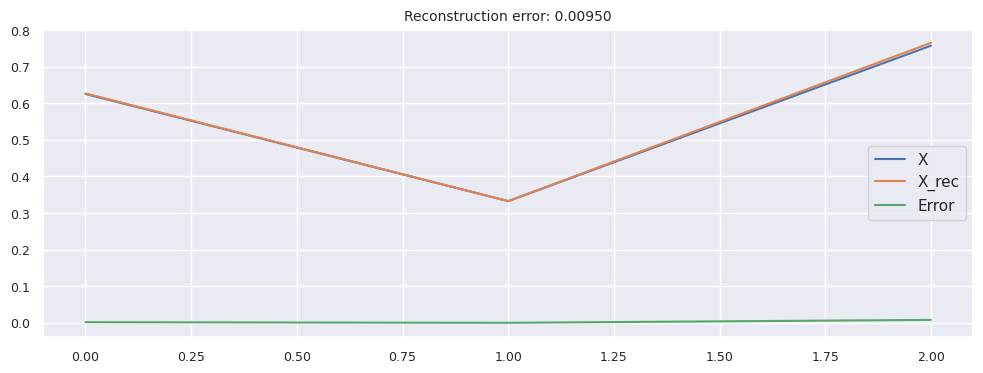

In [29]:
with torch.no_grad():
    X = X_test_tensor
    X = torch.unsqueeze(X, 2)
    X = X.to(device)
    reconstruction_test_data = model(X)
    difference_seqs = reconstruction_test_data-X
    reconstruction_errors_test = torch.sum(torch.abs(difference_seqs), dim=1)
    for i in range(5):
        plt.plot(X[i], label='X')
        plt.plot(reconstruction_test_data[i], label='X_rec')
        plt.plot(difference_seqs[i], label='Error')
        plt.title(f'Reconstruction error: {reconstruction_errors_test[i].item():.5f}', fontsize=10)
        plt.tick_params(labelsize=9)
        plt.legend()
        plt.show()

These test set reconstructions look pretty similar to the training set reconstructions which is good. Let's determine the outliers of the test set through applying the threshold and also add these results to the corresponding data frame for visualization purposes:

In [30]:
outliers_test = np.where(reconstruction_errors_test.flatten() > reconstruction_error_threshold, 1, 0)

df_test_split = df_test_split.assign(outliers = outliers_test)
df_test_split = df_test_split.assign(anomaly_score = reconstruction_errors_test.flatten())

Finally, let's visualize the test data and highlight the detected anomalies in red:

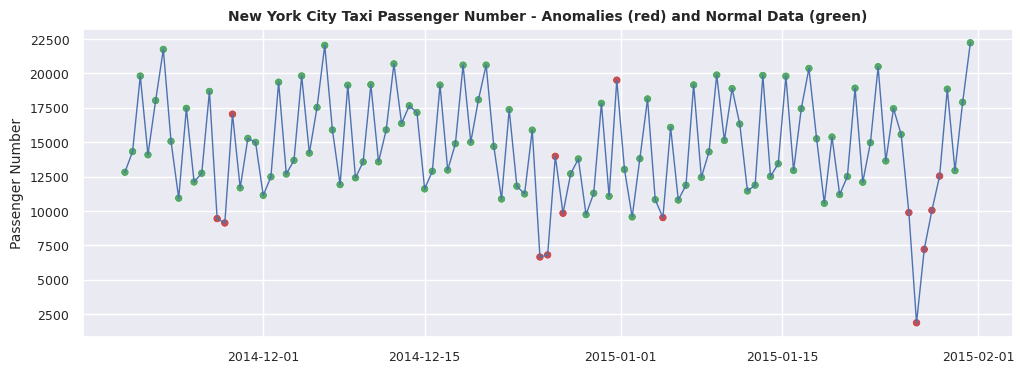

In [31]:
fig, ax = plt.subplots()
sns.lineplot(data=df_test_split, ax=ax, x="timestamp", y="value", linewidth=1)
sns.scatterplot(data=df_test_split, x="timestamp", y="value", ax=ax, hue="outliers", palette={1:'r', 0:'g'})
ax.axes.set_title("New York City Taxi Passenger Number - Anomalies (red) and Normal Data (green)",fontsize=10, weight='bold')
ax.set_xlabel("",fontsize=10)
ax.set_ylabel("Passenger Number",fontsize=10)
ax.tick_params(labelsize=9)
plt.legend([],[], frameon=False)
plt.show()

Overall, we have 14 detected anomalies from which 12 belong to the defined abnormal events of the test set. Although this seems to be quite good here, that also means we have 2 false positives and multiple triggered anomalies for each abnormal event which could be suboptimal in some applications as well. Even though there might be still some potential for further optimization, we are good with this for now and are also happy to have built a model with reasonable generalization capabilities :).

## **Conclusion**
In summary, we successfully achieved our goal of detecting the anomalies in the new york city taxi data set by training an autoencoder on the training dataset containing both normal data points and anomalies. Training on normal data points and the anomalies enabled us to reduce the data preparation effort because we did not need to sort out the anomalies from the training data. For the future, it would be cool to use this lstm autoencoder architecture on other datasets as well and see how it does there!